In [564]:
from dolfinx.io import XDMFFile
from dolfinx.mesh import meshtags_from_entities
from dolfinx.cpp.mesh import cell_entity_type
from dolfinx.io import distribute_entity_data
from dolfinx.graph import adjacencylist
from dolfinx.mesh import create_mesh
from dolfinx.cpp.mesh import to_type
from dolfinx.cpp.io import perm_gmsh
import numpy
from dolfinx.io import gmshio
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh
import gmsh
import warnings
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant,  Function, functionspace, assemble_scalar, Expression,
                         dirichletbc, form, locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, locate_entities, meshtags
from dolfinx.plot import vtk_mesh
from dolfinx import plot
from mpi4py import MPI
from ufl import (FacetNormal, Measure, SpatialCoordinate, TestFunction, TrialFunction, 
                 div, dot, dx, grad, inner, lhs, rhs, exp, tr, Identity, sym, nabla_div, indices, as_tensor)
import numpy as np
import pyvista
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
gmsh.initialize()

In [2]:
gmsh.model.add("test_mass")

In [3]:
cad = gmsh.model.geo
lc = 0.002


In [4]:
cad.addPoint(0, -0.05, 0.01, lc, 1)
cad.addPoint(0, 0.05, 0.01, lc, 2)
cad.addPoint(0, 0.05, -0.01, lc, 3)
cad.addPoint(0, -0.05, -0.01, lc, 4)
cad.addPoint(0,0,0, lc, 5)
cad.addLine(2, 3, 1)
cad.addLine(4, 1, 2)
cad.addCircleArc(1, 5, 2, 3)
cad.addCircleArc(3, 5, 4, 4)
cad.addCurveLoop([3, 1, 4, 2 ], 10)
cad.addPlaneSurface([10], 11)

11

In [5]:
vol = cad.extrude([(2, 11)], 0.03,0,0 )

In [6]:
cad.synchronize()

In [7]:
gmsh.model.addPhysicalGroup(3, [vol[1][1]], 41, "volume")
gmsh.model.addPhysicalGroup(2, [vol[0][1],vol[2][1], vol[3][1], vol[4][1], vol[5][1]], 42, "surface")

42

In [8]:
gmsh.model.mesh.generate(3)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Circle)
Info    : [ 30%] Meshing curve 4 (Circle)
Info    : [ 40%] Meshing curve 13 (Circle)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Circle)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 90%] Meshing curve 23 (Line)
Info    : [100%] Meshing curve 27 (Line)
Info    : Done meshing 1D (Wall 0.000606788s, CPU 0.000857s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 11 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 20 (Surface, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 24 (Surface, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 28 (Surface, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 32 (Surface, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 33 (Plane, Frontal-Delaunay)
Info    : Done 

In [9]:
gmsh.write('mirror2.msh')

Info    : Writing 'mirror2.msh'...
Info    : Done writing 'mirror2.msh'


In [10]:
model_rank = 0
mesh, cell_tags, facet_tags = model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, model_rank,3)

In [11]:
x = SpatialCoordinate(mesh)

#define physical parameters and boundary conditions
h = Constant(mesh, default_scalar_type(20)) 
Tex = Constant(mesh, default_scalar_type(273.15))  #External Temperature
kappa = Constant(mesh, default_scalar_type(139.4)) #Thermal Diffusivity
f = Constant(mesh, default_scalar_type(0.0))
P0 = Constant(mesh, default_scalar_type(0.5)) # Laser Power
r = Constant(mesh, default_scalar_type(0.003)) # Beam Radius
SB = Constant(mesh, default_scalar_type(5.67e-8)) #Stefan-Boltzmann Constant
emiss = Constant(mesh, default_scalar_type(0.71)) #Emissivity of Silicon
laser = lambda x: -P0 * (1/(2*np.pi*r**2))*exp(-((x[1])**2 + (x[2])**2)/(2*r**2))
laser2 = lambda x: -P0 * (1/(2*np.pi*r**2))*exp(-((x[0]-0.5)**2)/(2*r**2))
g = laser(x)
z = Constant(mesh, 3.352190)

radiation_flux = SB*emiss*(274**4 - Tex**4)
#Define function space and Standard Part of Variational Form

V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)
Delta_T = Function(V, name="Temperature_variation")
F = kappa * inner(grad(u), grad(v)) * dx - inner(f, v) * dx

In [12]:
#Creating Silicon Elasticity Tensor

def cubic_elasticity(c11, c12, c44):
    elastic_cubic = np.zeros(shape=(3,3,3,3))
    elastic_cubic[0,0,0,0] = c11
    elastic_cubic[0,0,1,1] = c12
    elastic_cubic[0,0,2,2] = c12
    elastic_cubic[1,1,0,0] = c12
    elastic_cubic[1,1,1,1] = c11
    elastic_cubic[1,1,2,2] = c12
    elastic_cubic[2,2,0,0] = c12
    elastic_cubic[2,2,1,1] = c12
    elastic_cubic[2,2,2,2] = c11
    elastic_cubic[1,2,1,2] = c44
    elastic_cubic[2,1,2,1] = c44
    elastic_cubic[0,2,0,2] = c44
    elastic_cubic[2,0,2,0] = c44
    elastic_cubic[0,1,0,1] = c44
    elastic_cubic[1,0,1,0] = c44
    return elastic_cubic
    



In [13]:
el = cubic_elasticity(165.7e9, 63.9e9, 79.6e9)
elastic = Constant(mesh, default_scalar_type(el))

In [14]:
mesh.topology.dim

3

In [15]:
# Boundary Conditions For Front Surface
def mark_entities(domain, dim, entities_dict):
    """Mark entities of specified dimension according to a geometrical marker function

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    dim : int
        Dimension of the entities to mark
    entities_dict : dict
        A dictionary mapping integer tags with a geometrical marker function {tag: marker(x)}

    Returns
    -------
    entities_tag array
    """
    marked_values = []
    marked_entities = []
    # number of non-ghosted entities
    num_entities_local = domain.topology.index_map(dim).size_local
    # Concatenate and sort the arrays based on indices
    for tag, location in entities_dict.items():
        entities = locate_entities(domain, dim, location)
        entities = entities[entities < num_entities_local]  # remove ghost entities
        marked_entities.append(entities)
        marked_values.append(np.full_like(entities, tag))
    marked_entities = np.hstack(marked_entities)
    marked_values = np.hstack(marked_values)
    sorted_entities = np.argsort(marked_entities)
    entities_tags = meshtags(
        domain, dim, marked_entities[sorted_entities], marked_values[sorted_entities]
    )
    return entities_tags


def front_surface(x):
    return np.isclose(x[0], 0)

def back_surface(x):
    return np.isclose(x[0], 0.03)

def sides(x):
    return np.logical_or(np.isclose(x[1], -0.05), np.isclose(x[1], 0.05))

def arc(x):
    return np.isclose(x[1]**2 +x[2]**2, 0.01**2 + 0.05**2)



tdim = mesh.topology.dim - 1
cell_markers = mark_entities(mesh, tdim, {1: front_surface, 2: back_surface, 3: sides, 4: arc})






In [16]:
ds = Measure("ds", domain=mesh, subdomain_data=cell_markers) #domain for boundary Condition

In [17]:
#Neumann Boundary Conditioncs
F += inner(g, v) * ds(2)

#Robin Boundary Conditions
# Convection
F+= h * inner(u - Tex, v)* ds(1)
F+= h * inner(u - Tex, v)* ds(2)
F+= h * inner(u - Tex, v)* ds(3)
F+= h * inner(u - Tex, v)* ds(4)
F+= z * inner(u - Tex, v)* ds(1)
F+= z * inner(u - Tex, v)* ds(2)
F+= z * inner(u - Tex, v)* ds(3)
F+= z * inner(u - Tex, v)* ds(4)

#Radiation
#F += SB*emiss* inner(u - Tex, v)* ds(2)
#F+= SB*emiss* inner(u**4 - Tex**4, v)* ds(2)
#F+= SB*emiss* inner(u**4 - Tex**4, v)* ds(3)
#F+= SB*emiss* inner(u**4 - Tex**4, v)* ds(4)


In [18]:

#Radiation
#F += inner(radiation_flux, v)* ds(1)
#F += inner(radiation_flux, v)* ds(2)
#F += inner(radiation_flux, v)* ds(3)
#F += inner(radiation_flux, v)* ds(4)

In [19]:
#Dirichlet Boundary Condition
bcs = []

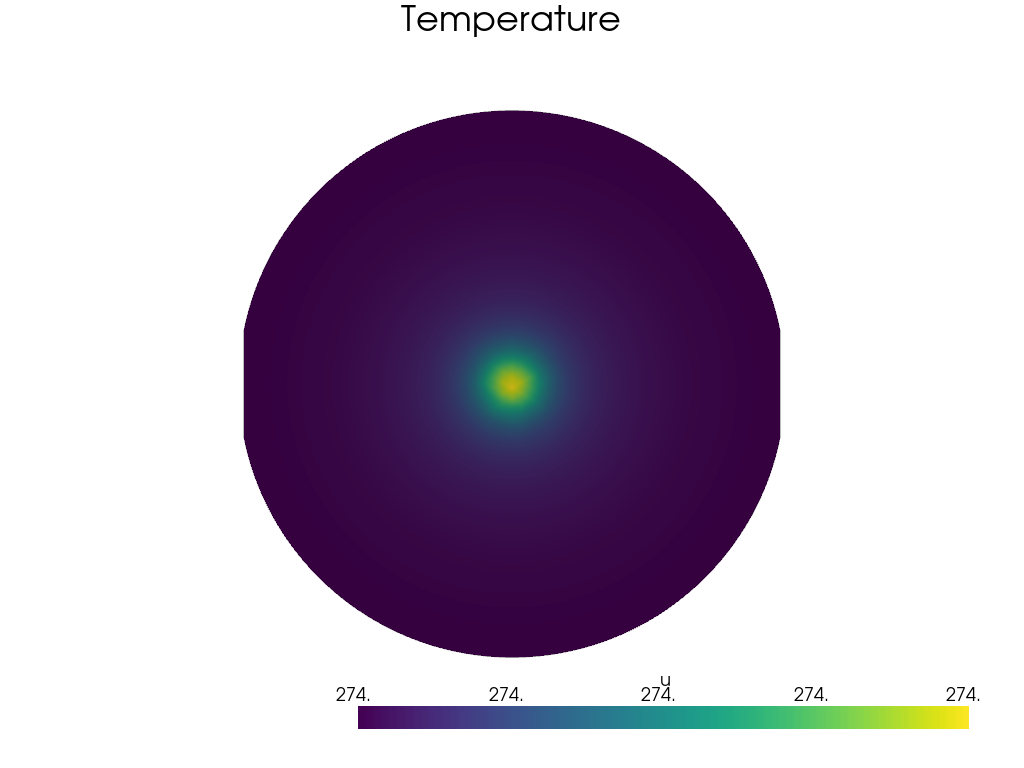

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [697]:
# Solve linear variational problem
a = lhs(F)
L = rhs(F)
problem = LinearProblem(a, L, u=Delta_T, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Visualize solution
pyvista.start_xvfb()
pyvista.global_theme.cmap = 'viridis'
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("Temperature", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=False)
plotter.view_yz()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("temperature_map.png")
plotter.screenshot("temperature_map.png")

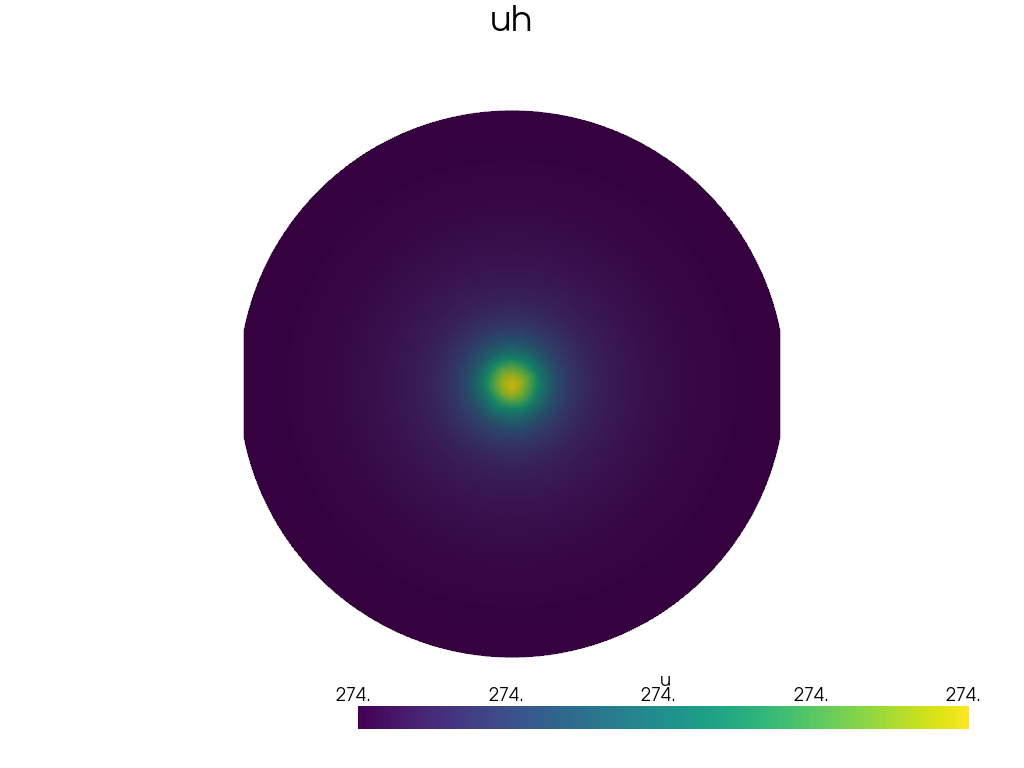

In [21]:
# Visualize solution
pyvista.start_xvfb()
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=False)
plotter.view_yz()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("robin_neumann_dirichlet.png")

In [22]:
np.amax(uh.x.array) - np.amin(uh.x.array)

0.20997284870372823

In [24]:
i,j,k,l = indices(4)

def fixed(x):
    return np.logical_and(np.less(x[1]**2 +x[2]**2, 0.001**2), np.isclose(x[0],0))


gdim = mesh.geometry.dim
E = Constant(mesh, 130e9)
nu = Constant(mesh, 0.27)
mu = E / 2 / (1 + nu)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
alpha = Constant(mesh, 2.6e-6)
rho = 2329
g = 9.8

f2 = Constant(mesh, (0.0, 0.0, 0.0))
#elastic_tensor = as_tensor(elastic, (i, j, k, l))

def eps(v):
    return sym(grad(v))

"""
def sigma(v, Delta_T):
    return (
        lmbda * tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * (Delta_T-Tex)
    ) * Identity(gdim) + 2.0 * mu * eps(v)
"""

def sigma(v, Delta_T):
    return (
        as_tensor(elastic[i,j,k,l]*(sym(grad(v))[k,l] - alpha * (Delta_T - Tex) * Identity(gdim)[k,l]),(i,j))
    )


Vu = functionspace(mesh, ("Lagrange", 2, (gdim,)))
du = TrialFunction(Vu)
u_ = TestFunction(Vu)
Wint = inner(sigma(du, (Delta_T)), eps(u_)) * dx
aM = lhs(Wint)
LM = rhs(Wint) + inner(f2, u_) * dx

lateral_dofs_u = locate_dofs_geometrical(Vu, fixed)
bcu = [dirichletbc(np.zeros((gdim,)), lateral_dofs_u, Vu)]


In [25]:
ux = Function(Vu, name="Displacement")
problem = LinearProblem(aM, LM, u=ux, bcs=bcu)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, tetrahedron, 1, equispaced, unset, False, float64, []), (3,)), 0), blocked element (Basix element (P, tetrahedron, 2, gll_warped, unset, False, float64, []), (3,))), 1)

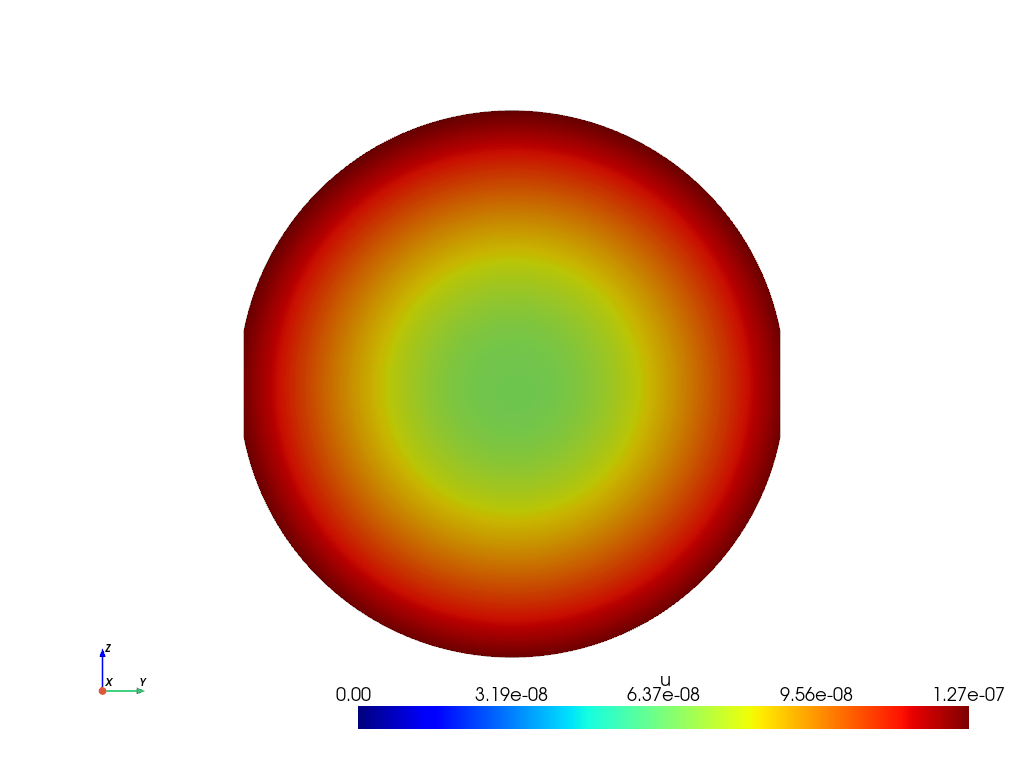

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [696]:
pyvista.start_xvfb()
pyvista.global_theme.cmap = 'jet'

# Create plotter and pyvista grid
p = pyvista.Plotter(off_screen=False)
topology, cell_types, geometry = plot.vtk_mesh(Vu)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = ux.x.array.reshape((geometry.shape[0], 3))
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=False)
p.show_axes()
p.view_yz()

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("displacement.png")

p.screenshot("displacement.png")

In [29]:
def epsilon2(u):
    return sym(grad(u))

gdim = mesh.geometry.dim
Strain = functionspace(mesh, ("Lagrange", 1, (mesh.geometry.dim, 3)))
strain = Function(Strain)
strain_expr = Expression(epsilon2(ux), Strain.element.interpolation_points())

In [30]:
strain.interpolate(strain_expr)

In [31]:
strain_array = strain.x.array.reshape((int(strain.x.array.shape[0]/9), 3, 3))

In [161]:
def rot_mat(rot_z, rot_y, rot_x):
    a = rot_z
    b = rot_y
    y = rot_x
    mat = np.array([[np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(y) - np.sin(a)*np.cos(y), np.cos(a)*np.sin(b)*np.cos(y) + np.sin(a)*np.sin(y)],[np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(y) + np.cos(a)*np.cos(y), np.sin(a)*np.sin(b)*np.cos(y) - np.cos(a)*np.sin(y)], [-1*np.sin(b), np.cos(b)*np.sin(y), np.cos(b)*np.cos(y)]])
    return mat


def h_eigenvalues(mat):
    a = mat[0, 0]
    b = mat[1, 1]
    c = mat[0, 1]

    l1 = (a + b - np.sqrt(4 * c ** 2 + (a - b) ** 2)) / 2
    l2 = (a + b + np.sqrt(4 * c ** 2 + (a - b) ** 2)) / 2
    return l1, l2


def r_index(mat):
    l1, l2 = h_eigenvalues(mat)
    return (1/np.sqrt(l1)) - (1/np.sqrt(l2))


def stress(s1, s2, s3, s4, s5, s6):
    arr = np.array([s1, s2, s3, s4, s5, s6])
    return arr


def photoelastic(p11, p12, p44):
    arr = np.array([[p11, p12, p12, 0, 0, 0], [p12, p11, p12, 0,0,0], [p12, p12, p11, 0,0,0],[0,0,0,p44,0,0],[0,0,0,0,p44,0],[0,0,0,0,0,p44]])
    return arr


def elastic(PR, YM):
    arr = np.array([[1, -1*PR, -1*PR,0,0,0],[-1*PR, 1, -1*PR, 0,0,0], [-1*PR, -1*PR, 1,0,0,0],[0,0,0,1+PR,0,0],[0,0,0,0,1+PR,0],[0,0,0,0,0,1+PR]])
    arr = arr * (1/YM)
    return arr

def delta_b(PR, YM, p11, p12, p44, s1, s2, s3, s4, s5, s6):
    arr = np.dot(photoelastic(p11, p12, p44), stress(s1, s2, s3, s4, s5, s6))
    return arr

def b_0(nx, ny, nz):
    arr = np.array([1/(nx**2), 1/(ny**2), 1/(nz**2), 0,0,0])
    return arr


def b_new(PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz):
    delB = delta_b(PR, YM, p11, p12, p44, s1, s2, s3, s4, s5, s6)
    B0 = b_0(nx, ny, nz)
    B = delB + B0
    arr2 = np.array([[B[0], B[5], B[4]], [B[5], B[1], B[3]], [B[4], B[3], B[2]]])
    return arr2

def fast_axis(rot_z, rot_x, rot_y, PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz):
    b = b_new(PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz)
    rot = rot_mat(rot_z, rot_x, rot_y)
    rotated = np.dot(rot, np.dot(b, np.linalg.inv(rot)))
    small_b = rotated[1:, 1:]
    w, v = np.linalg.eig(small_b) 
    cos_a = np.arctan(v[0,1]/v[0,0])
    return cos_a

def slow_axis(rot_z, rot_x, rot_y, PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz):
    b = b_new(PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz)
    rot = rot_mat(rot_z, rot_x, rot_y)
    rotated = np.dot(rot, np.dot(b, np.linalg.inv(rot)))
    small_b = rotated[1:, 1:]
    w, v = np.linalg.eig(small_b) 
    cos_a = np.dot(v[0], v[1])/(np.linalg.norm(v[0]) * np.linalg.norm(v[1]))
    return cos_a


def birefringence(rot_z, rot_x, rot_y, PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz):
    b = b_new(PR, YM, s1, s2, s3, s4, s5, s6, p11, p12, p44, nx, ny, nz)
    rot = rot_mat(rot_z, rot_x, rot_y)
    rotated = np.dot(rot, np.dot(b, np.linalg.inv(rot)))
    small_b = rotated[1:, 1:]
    delta_n = r_index(small_b)
    return delta_n


In [162]:
npoints = strain_array.shape[0]
dn = np.zeros(npoints)
angle_fast = np.zeros((npoints))
angle_slow = np.zeros(npoints)
for x in range(npoints):
    a = strain_array[x]
    dn[x] = birefringence(rot_z=0, rot_x=0, rot_y=0, PR=0.27, YM=130e9, s1=a[0,0], s2=a[1,1], s3=a[2,2],s4= a[1,2], s5=a[0,2], s6=a[0,1], p11=-0.094, p12=0.017,p44= -0.051, nx=3.48, ny=3.48, nz=3.48)
    angle_fast[x] = fast_axis(rot_z=0, rot_x=0, rot_y=0, PR=0.27, YM=130e9, s1=a[0,0], s2=a[1,1], s3=a[2,2],s4= a[1,2], s5=a[0,2], s6=a[0,1], p11=-0.094, p12=0.017,p44= -0.051, nx=3.48, ny=3.48, nz=3.48)
    angle_slow[x] = slow_axis(rot_z=0, rot_x=0, rot_y=0, PR=0.27, YM=130e9, s1=a[0,0], s2=a[1,1], s3=a[2,2],s4= a[1,2], s5=a[0,2], s6=a[0,1], p11=-0.094, p12=0.017,p44= -0.051, nx=3.48, ny=3.48, nz=3.48)



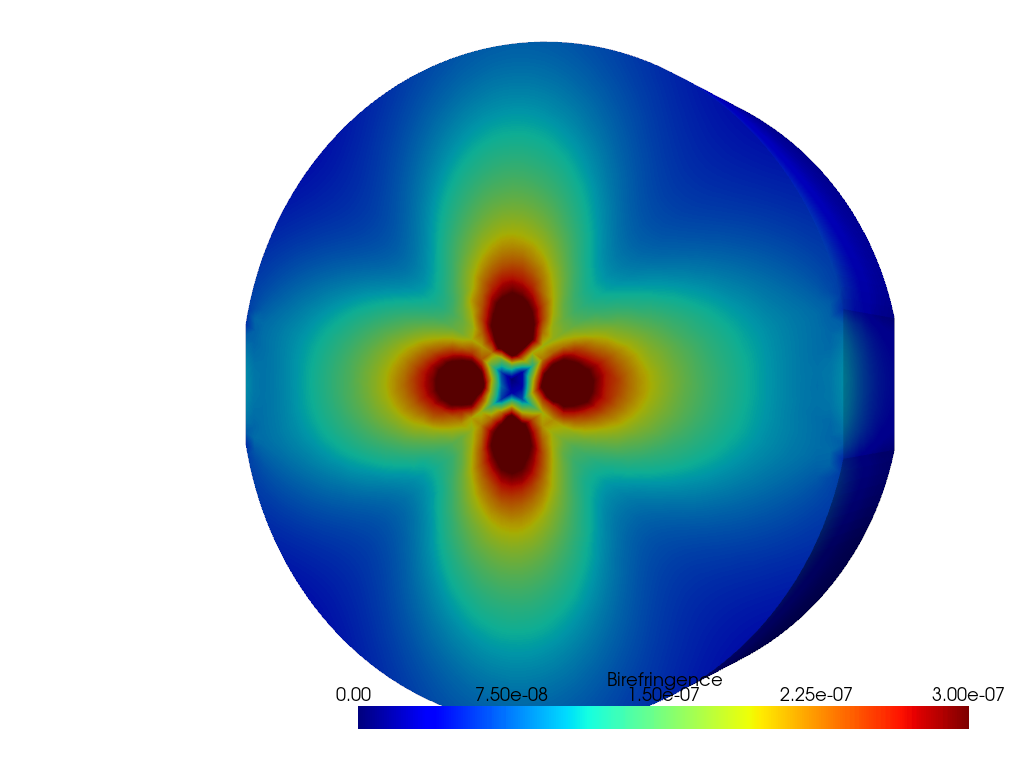

In [152]:
pyvista.global_theme.cmap = 'jet'
pyvista.start_xvfb()


camera = pyvista.Camera()
camera.position = (0.22, 0, -0.1)
camera.focal_point = (0.03, 0, 0)

# Create plotter and pyvista grid
p = pyvista.Plotter(off_screen=False)
topology, cell_types, geometry = plot.vtk_mesh(Strain)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["Birefringence"] = dn
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
#warped = grid.warp_by_scalar("Birefringence", factor=0)
warped = grid.rotate_x(90,point=(0.,0.,0.), inplace=False)
actor_1 = p.add_mesh(warped, show_edges=False, clim=[0, 3e-7])
p.camera = camera
p.show_axes

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

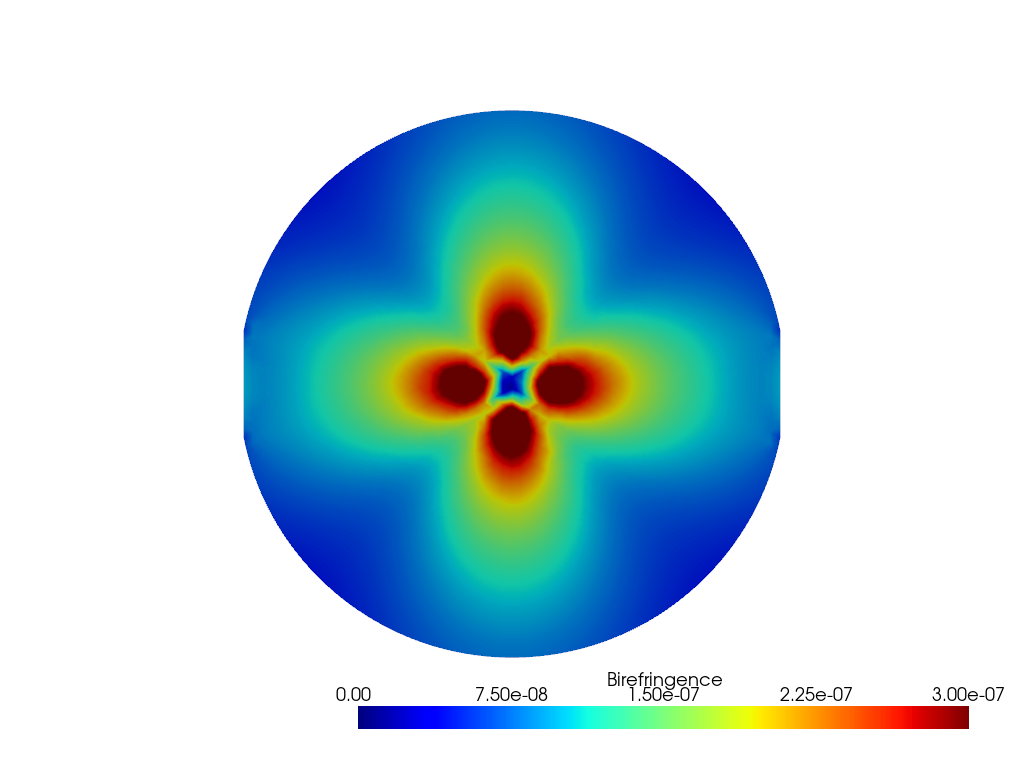

In [71]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter(off_screen=False)
topology, cell_types, geometry = plot.vtk_mesh(Strain)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["Birefringence"] = dn
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
#warped = grid.warp_by_scalar("Birefringence", factor=0)
warped = grid.rotate_z(0,point=(0.,0.,0.), inplace=False)
actor_1 = p.add_mesh(warped, show_edges=False, clim=[0, e-7])
p.view_yz()

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

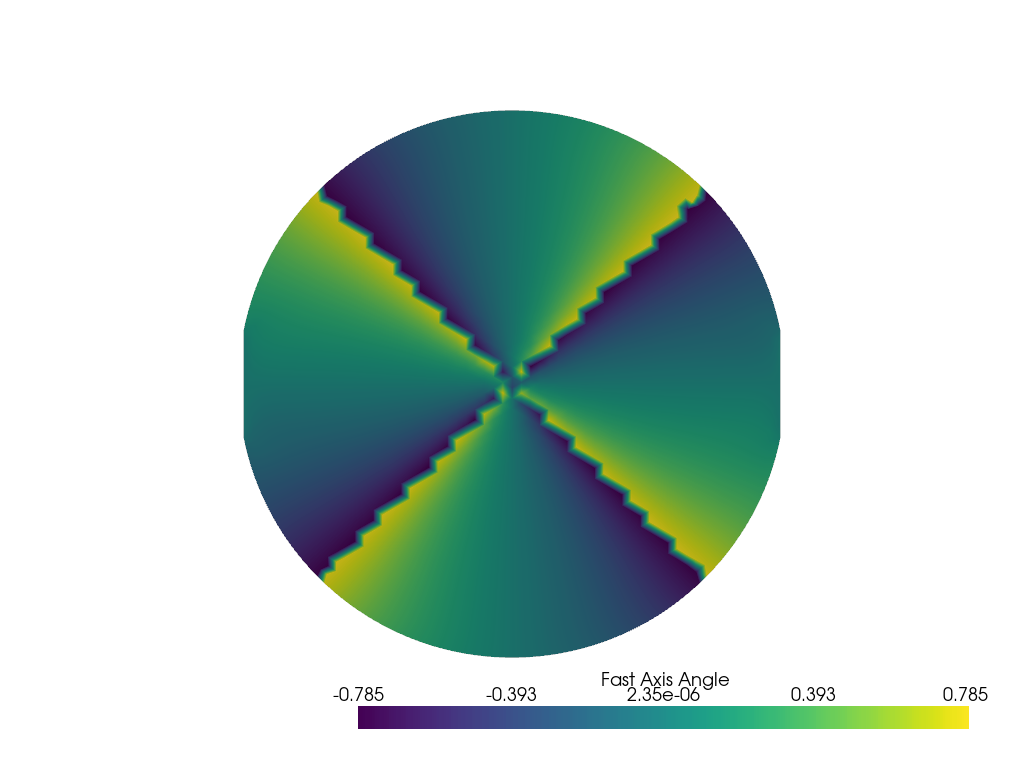

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [700]:
pyvista.start_xvfb()
pyvista.global_theme.cmap = 'viridis'
# Create plotter and pyvista grid
p = pyvista.Plotter(off_screen=False)
topology, cell_types, geometry = plot.vtk_mesh(Strain)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["Fast Axis Angle"] = angle_fast
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
#warped = grid.warp_by_scalar("Birefringence", factor=0)
warped = grid.rotate_z(0,point=(0.,0.,0.), inplace=False)
actor_1 = p.add_mesh(warped, show_edges=False)
p.view_yz()

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")


p.screenshot("fast_axis_angle.png")

In [74]:
np.amax(angle_slow)

0.0

In [431]:
def wave_plate_mat(birefringence, dist, wave_length, angle):
    eta = birefringence * dist * 2 * np.pi / wave_length
    a = np.cos(eta,dtype=np.complex64) + np.sin(eta,dtype=np.complex64)*1.0j
    b = np.cos(-eta/2,dtype=np.complex64) + np.sin(-eta/2,dtype=np.complex64)* 1.0j
    return b * np.array([[np.cos(angle,dtype=np.complex64)**2+a*np.sin(angle,dtype=np.complex64)**2, (1 - a)*np.cos(angle,dtype=np.complex64)*np.sin(angle,dtype=np.complex64)],
                     [(1-a)*np.cos(angle,dtype=np.complex64)*np.sin(angle,dtype=np.complex64), np.sin(angle,dtype=np.complex64)**2 + a*np.cos(angle,dtype=np.complex64)**2]], dtype=np.complex64)

In [433]:
from dolfinx import geometry
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
tol = 0.0001
n = 100
x_line = np.linspace(0.01, 0.03 - tol, n)
y_points = np.linspace(-0.04, 0.04, n)
z_points = np.linspace(-0.04, 0.04, n)
matrices = np.zeros((n, n, 2, 2), dtype=np.complex64)
dn_mat = np.zeros((n, n, 1))
#yv, zv = np.meshgrid(y_points, z_points)


In [463]:
for k in range(n):
    for j in range(n):
        points = np.zeros((3, n))
        points[0] = x_line
        points[1] = y_points[k]
        points[2] = z_points[j]
        strain_values = []
        cells = []
        points_on_proc = []

        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)

        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)

        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        points_on_proc = np.array(points_on_proc, dtype=np.float64)
        strain_values = strain.eval(points_on_proc, cells)
        strain_val_reshape = strain_values.reshape((strain_values.shape[0],3,3))
        birefringence_line = np.zeros(strain_values.shape[0])
        angle_line = np.zeros(strain_values.shape[0])
        for i in range(strain_values.shape[0]):
            a = strain_val_reshape[i]
            birefringence_line[i] = birefringence(rot_z=0, rot_x=0, rot_y=0, PR=0.27, YM=130e9, s1=a[0,0], s2=a[1,1], s3=a[2,2],s4= a[1,2], s5=a[0,2], s6=a[0,1], p11=-0.094, p12=0.017,p44= -0.051, nx=3.48, ny=3.48, nz=3.48)
            angle_line[i] = fast_axis(rot_z=0, rot_x=0, rot_y=0, PR=0.27, YM=130e9, s1=a[0,0], s2=a[1,1], s3=a[2,2],s4= a[1,2], s5=a[0,2], s6=a[0,1], p11=-0.094, p12=0.017,p44= -0.051, nx=3.48, ny=3.48, nz=3.48)
        dist = x_line[1] - x_line[0]
        wavelength = 1995e-9
        line_mat = np.identity(2, dtype=np.complex64)
        for i in range(strain_values.shape[0]):
            line_mat = np.dot(line_mat,  wave_plate_mat(birefringence_line[(strain_values.shape[0]-1)-i], dist, wavelength, angle_line[(strain_values.shape[0]-1)-i]))
        matrices[k, j] = line_mat
        dn_mat[k,j] = np.mean(birefringence_line)


        

In [464]:
x_basis = np.array([1.0,0.0], dtype=np.float64)
y_basis = np.array([0.0,1.0], dtype=np.float64)

x_polarisation = np.dot(matrices[:,:], x_basis)
y_polarisation = np.dot(matrices[:,:], y_basis)

x_pol_phase = np.zeros((n,n,2), dtype=np.float64)
y_pol_phase = np.zeros((n,n,2), dtype=np.float64)
y_pol_power = np.zeros((n,n,2), dtype=np.float64)
x_pol_phase_x = np.zeros((n,n), dtype=np.float64)



In [465]:
x_pol_phase = np.arcsin(np.imag(x_polarisation/np.abs(x_polarisation)))
x_pol_power = np.abs(x_polarisation)**2
y_pol_phase = np.arcsin(np.imag(y_polarisation/np.abs(y_polarisation)))
y_pol_power = np.abs(y_polarisation)**2
yv, zv = np.meshgrid(y_points, z_points)

In [466]:
x_pol_phase_x.shape

(100, 100)

In [541]:
x_pol_phase_x = x_pol_phase[:,:,0]
x_pol_phase_y = x_pol_phase[:,:,1]
y_pol_phase_x = y_pol_phase[:,:,0]
y_pol_phase_y = y_pol_phase[:,:,1]
x_pol_power_x = x_pol_power[:,:,0]
x_pol_power_y = x_pol_power[:,:,1]
y_pol_power_x = y_pol_power[:,:,0]
y_pol_power_y = y_pol_power[:,:,1]

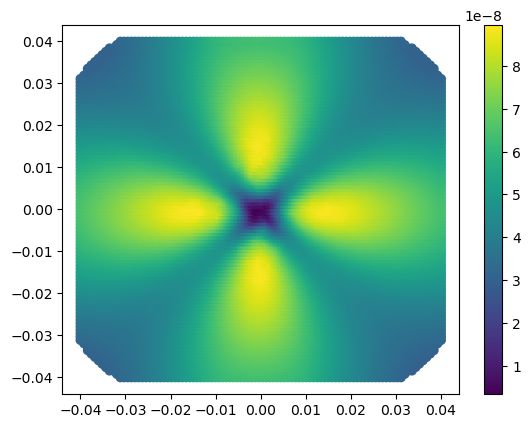

In [701]:
plt.figure(1)
plt.scatter(yv, zv, c=dn_mat)

plt.colorbar()
plt.savefig("birefringence_map.png")

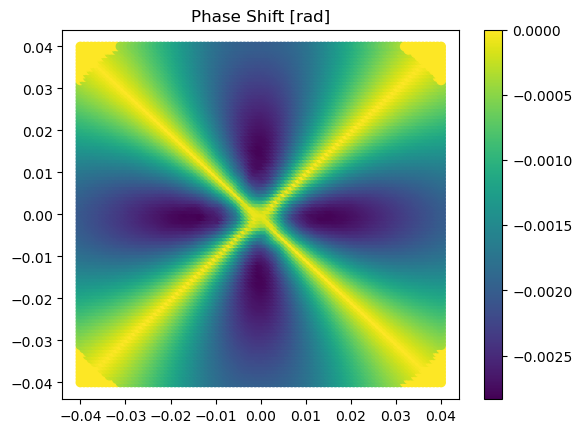

In [702]:
plt.figure(2)
plt.scatter(yv, zv, c=x_pol_phase_x)
plt.colorbar()
plt.title("Phase Shift [rad]")
plt.savefig("x_to_x_phase_map.png")
np.savetxt( "phase_map1.txt", x_pol_phase_x,)

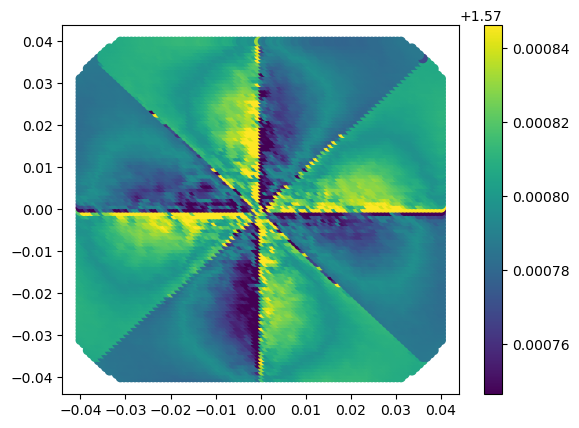

In [563]:
plt.figure(3)
plt.scatter(yv, zv, c=np.mod(x_pol_phase_y, np.pi))
plt.clim(np.pi/2 - 0.5e-4,np.pi/2 + 0.5e-4)
plt.colorbar()

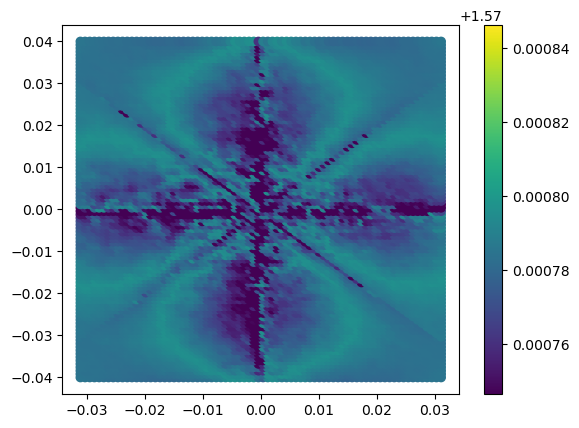

In [709]:
plt.figure(3)
period = np.pi
unwrapped = np.unwrap(x_pol_phase_y, period=period*2, axis=1)

unwrapped2 = np.unwrap(x_pol_phase_y, period=period*2, axis=0)
plt.scatter(yv, zv, c=np.abs(unwrapped2))
plt.clim(np.pi/2-0.5e-4, np.pi/2 + 0.5e-4)
plt.savefig("x_to_y_phase_map.png")
plt.colorbar()

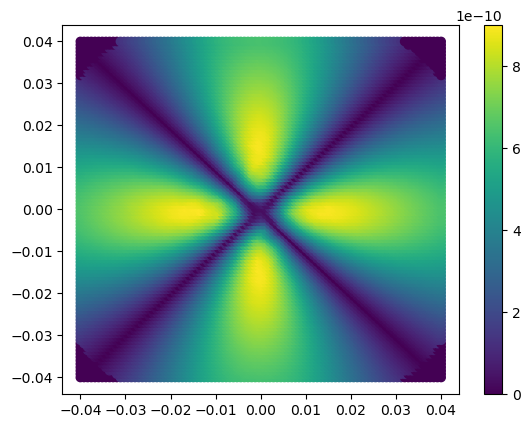

In [558]:
plt.figure(4)
plt.scatter(yv, zv, c=y_pol_phase_y*1996e-9/(np.pi*2))
plt.colorbar()

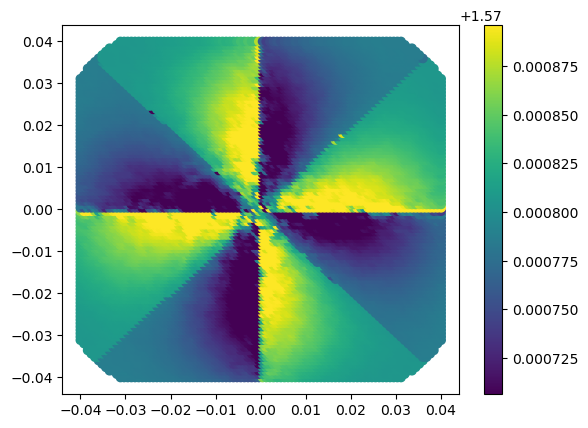

In [587]:
plt.figure(4)
plt.scatter(yv, zv, c=np.mod(y_pol_phase_x,np.pi))
plt.clim(np.pi/2 - 0.9e-4,np.pi/2 + 1e-4)
plt.colorbar()

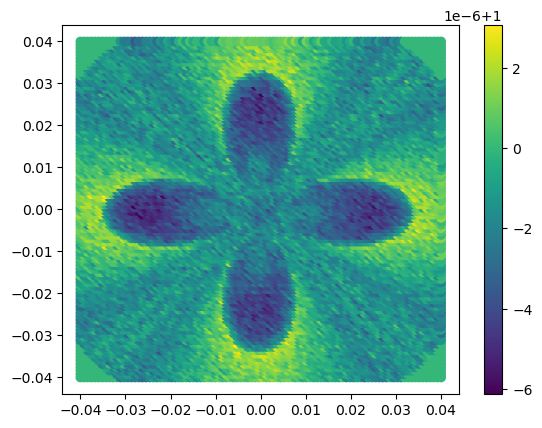

In [710]:
plt.figure(5)
plt.scatter(yv, zv, c=x_pol_power_x)
plt.colorbar()
plt.savefig("x_to_x_power_map.png")

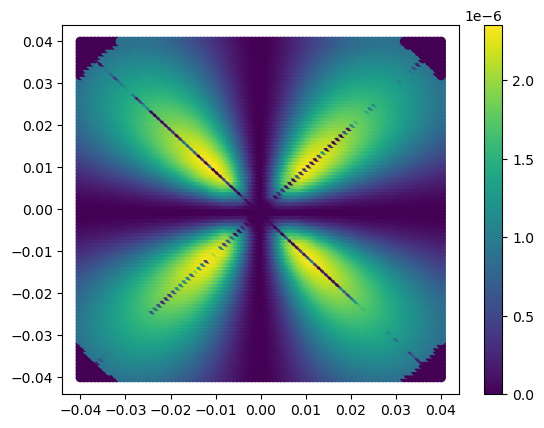

In [711]:
plt.figure(7)
plt.scatter(yv, zv, c=x_pol_power_y)
plt.savefig("x_to_y_power_map.png")
plt.colorbar()

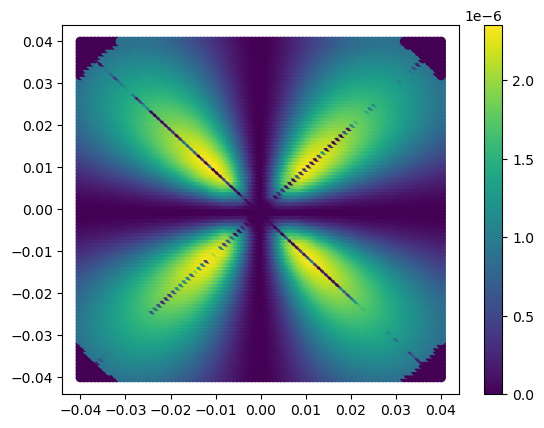

In [548]:
plt.figure(7)
plt.scatter(yv, zv, c=y_pol_power_x)
plt.colorbar()

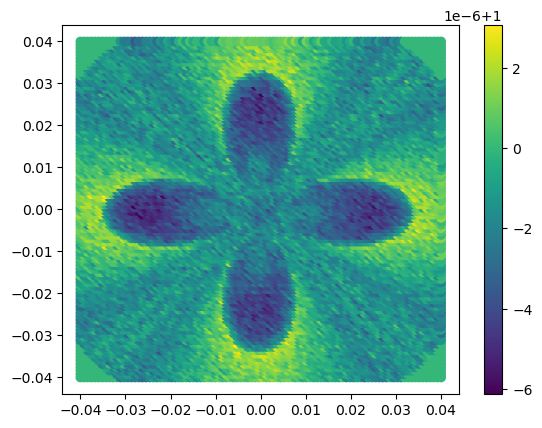

In [550]:
plt.figure(8)
plt.scatter(yv, zv, c=y_pol_power_y)
plt.colorbar()